# Exercise 6

In [13]:
# Basic
import random

# Data
import numpy as np
import matplotlib.pyplot as plt

# ML
from sklearn.model_selection import train_test_split

# DL
from tensorflow.keras.datasets import mnist

## 1. Data

In [7]:
(X_train, y_train),(X_test, y_test) = mnist.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=42)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((48000, 28, 28),
 (48000,),
 (12000, 28, 28),
 (12000,),
 (10000, 28, 28),
 (10000,))

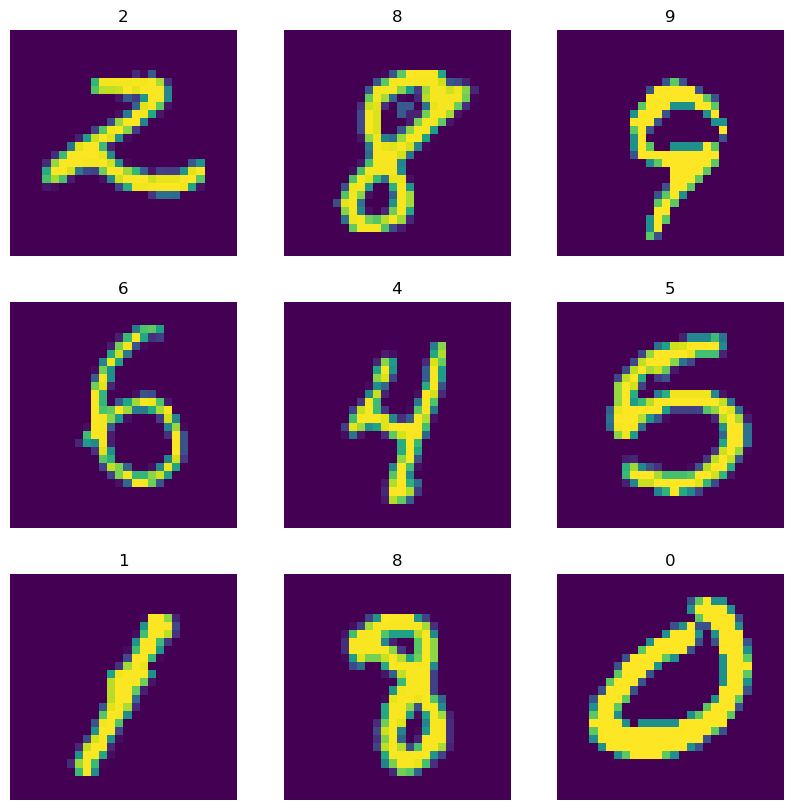

In [42]:
GRID_SIZE = 3

pairs = list(zip(X_train, y_train))
samples = random.sample(pairs, GRID_SIZE**2)

fig, ax = plt.subplots(GRID_SIZE, GRID_SIZE, figsize=(10, 10))
for i, (img, digit) in enumerate(samples):
    row, col = i//GRID_SIZE, i%GRID_SIZE
    ax[row, col].imshow(img)
    ax[row, col].set_title(digit)
    ax[row, col].axis('off')

## 2. Model

In [46]:
class Layer:
    def __init__(self, size, activation_fn='relu'):
        self.size = size
        self.activation_fn = {
            'relu': lambda x: np.maximum(0, x)
        }[activation_fn]
        self.activation_grad = {
            'relu': lambda x: np.where(x > 0, 1, 0)
        }[activation_fn]

In [49]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=1)

In [50]:
class NeuralNetworkClassifier:
    def __init__(self, input_size, layers, num_classes):
        self.input_size
        self.layers = layers
        self.num_classes = num_classes

        self.__create_weights()

    def __create_weights(self):
        self.weights = []
        self.activations = []

    def fit(self, X, y):
        return self

    def predict_proba(self, X):
        logits = X
        for w, act in zip(self.weights, self.activations):
            logits = act(logits @ w)
        
        return softmax(logits)

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)    

    def score(self, X, y):
        return (self.predict(X) == y).sum() / len(y)

## 3. Training

In [ ]:
nn_clf = NeuralNetworkClassifier(layers=[
    Layer(256, activation_fn='relu'),
    Layer(128, activation_fn='relu'),
    Layer(64, activation_fn='relu')
], num_classes=10).fit(X_train, y_train)

nn_clf.score(X_val, y_val)

## 4. Evaluation

In [ ]:
nn_clf.score(X_test, y_test)